In [2]:
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from neurasort.preprocessing import free_whisking_preprocessing_pipe

In [48]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.inspection import permutation_importance

In [4]:
raw_predictors_free_whisking = pd.read_csv("raw_predictors_free_whisking.csv")
preprocessing_pipe = free_whisking_preprocessing_pipe()
class_weights = (1 - raw_predictors_free_whisking["cell_type"].value_counts() / raw_predictors_free_whisking["cell_type"].shape[0]).to_dict()
raw_predictors_free_whisking

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,Cell_APThreshold_Slope,Cell_Depth,Cell_Layer,Cell_tdTomatoExpressing
0,EXC,3.25,-0.028422,0.563846,-0.038375,0.005196,0.000043,0.000518,10.0,229.0,L2/3,False
1,EXC,0.20,-0.033953,1.012500,-0.049049,0.004335,0.000053,0.000485,10.0,350.0,L2/3,False
2,EXC,0.05,-0.039291,3.350000,-0.050940,0.005286,0.000063,0.000519,10.0,350.0,L2/3,False
3,EXC,0.00,0.000000,0.000000,-0.047544,0.004778,0.000057,0.000557,10.0,350.0,L2/3,False
4,EXC,0.15,-0.033361,1.733333,-0.046490,0.002881,0.000031,0.000403,10.0,244.0,L2/3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
492,SST,6.60,-0.047992,0.564015,-0.056633,0.003752,0.000066,0.000438,20.0,196.0,L2/3,True
493,SST,6.80,-0.047427,0.578676,-0.056827,0.004175,0.000071,0.000514,20.0,196.0,L2/3,True
494,SST,7.50,-0.047400,0.589667,-0.056011,0.004038,0.000067,0.000460,20.0,196.0,L2/3,True
495,SST,5.50,-0.048279,0.580455,-0.056918,0.003525,0.000054,0.000430,20.0,196.0,L2/3,True


In [88]:
X = raw_predictors_free_whisking.drop("cell_type", axis=1)
y = raw_predictors_free_whisking["cell_type"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf', "#422d96", "#80186b", "#b54f00"]

In [89]:
gbclf_pipe = deepcopy(preprocessing_pipe)
gbclf_pipe.steps.append(
    ("clf", GradientBoostingClassifier(
            random_state=0, 
            learning_rate=0.21421828028126513, 
            n_estimators=54
        )
    )
)

svclf_pipe = deepcopy(preprocessing_pipe)
svclf_pipe.steps.append(
    ("clf", LinearSVC(
            random_state=0,
            C=15.427393422403167,
            max_iter=500,
            class_weight=class_weights,
            multi_class='crammer_singer',
            penalty="l2",
            dual='auto',
        )
    )
)

rfclf_pipe = deepcopy(preprocessing_pipe)
rfclf_pipe.steps.append(
    ("clf", RandomForestClassifier(
            random_state=0, 
            class_weight=class_weights,
            criterion='gini',
            n_estimators=226
        )
    )
)

In [90]:
model_names = ["GB", "SVM", "RF"]
models = [gbclf_pipe, svclf_pipe, rfclf_pipe]
for model_name, model in zip(model_names, models):
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
        scoring="f1_weighted"
    )
    print(f"{model_name}: mean = {scores.mean()}, std = {scores.std()}")

GB: mean = 0.9496626964080669, std = 0.01536628230245472


/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

SVM: mean = 0.9499586027735496, std = 0.017881836226441884
RF: mean = 0.9576891077947419, std = 0.013231325255019676


# Gradient Boosting

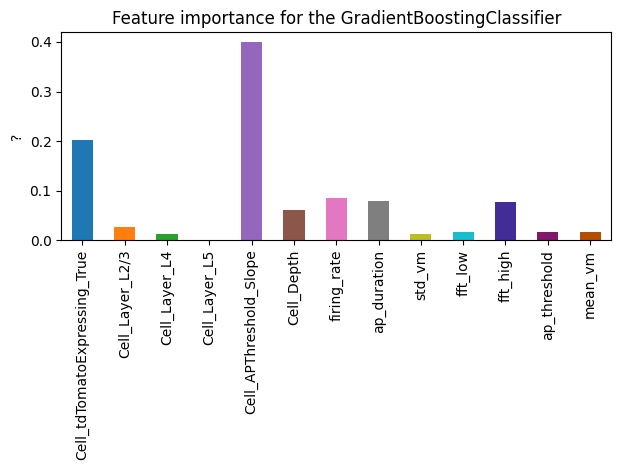

In [111]:
gbclf_pipe.fit(X, y)
fig, ax = plt.subplots()

gb_impotances = pd.Series(gbclf_pipe.named_steps.clf.feature_importances_, index=gbclf_pipe.named_steps.clf.feature_names_in_)
gb_impotances.plot.bar(ax=ax, color=colors)
ax.set_title(f"Feature importance for the GradientBoostingClassifier")
ax.set_ylabel("?")
fig.tight_layout()
plt.show()
plt.show()

In [114]:
gbclf_pipe.named_steps.clf.estimators_.shape

(54, 4)

# SVM

https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


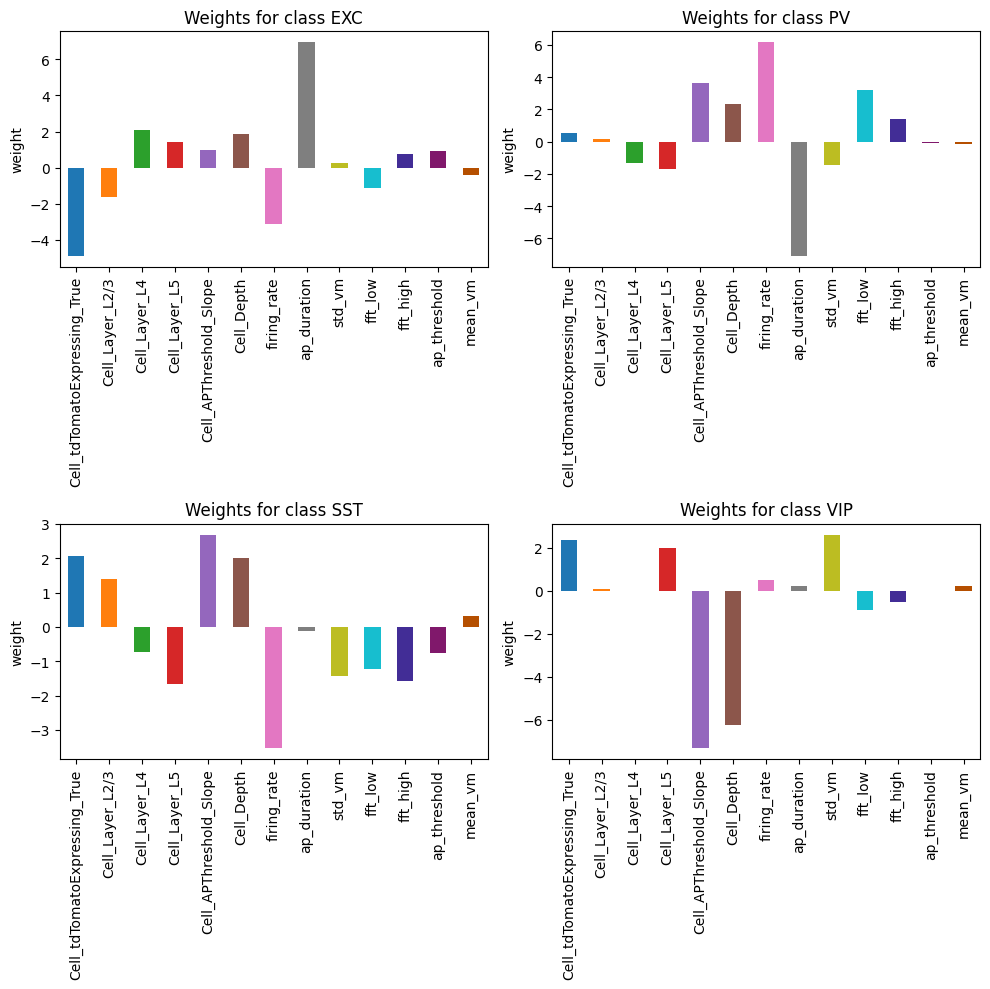

In [98]:
svclf_pipe.fit(X, y)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    svm_impotances = pd.Series(svclf_pipe.named_steps.clf.coef_[i], index=svclf_pipe.named_steps.clf.feature_names_in_)
    svm_impotances.plot.bar(ax=ax, color=colors)
    ax.set_title(f"Weights for class {svclf_pipe.named_steps.clf.classes_[i]}")
    ax.set_ylabel("weight")
    # for i in ax.containers:
    #     ax.bar_label(
    #         i,
    #     )
fig.tight_layout()
plt.show()
plt.show()

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


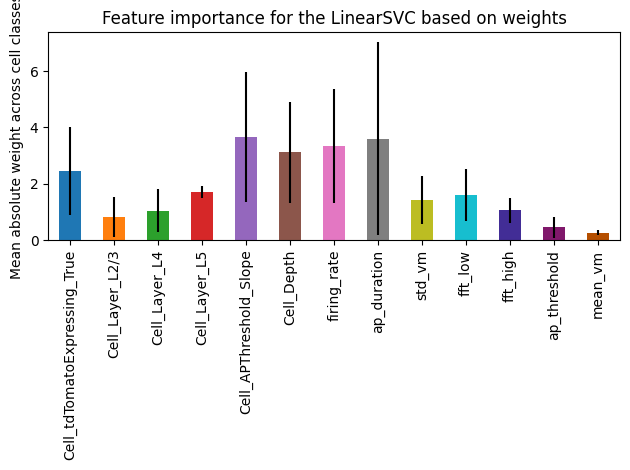

In [107]:
svclf_pipe.fit(X, y)
fig, ax = plt.subplots()

svm_impotances = pd.Series(np.mean(np.abs(svclf_pipe.named_steps.clf.coef_), axis=0), index=svclf_pipe.named_steps.clf.feature_names_in_)
std = np.std(np.abs(svclf_pipe.named_steps.clf.coef_), axis=0)
svm_impotances.plot.bar(ax=ax, color=colors, yerr=std)
ax.set_title(f"Feature importance for the LinearSVC based on weights")
ax.set_ylabel("Mean absolute weight across cell classes")
fig.tight_layout()
plt.show()
plt.show()

<Axes: xlabel='Cell_tdTomatoExpressing', ylabel='count'>

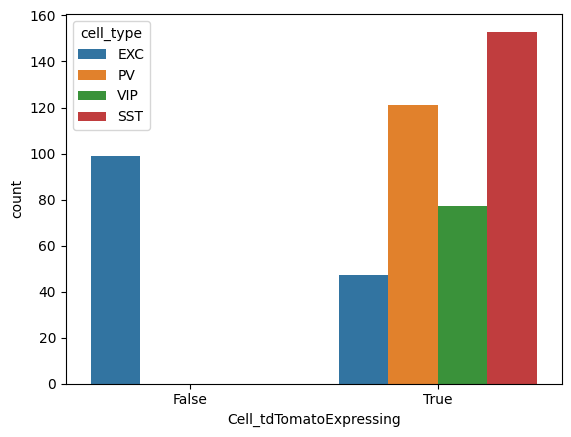

In [96]:
sns.countplot(
    data=raw_predictors_free_whisking,
    x="Cell_tdTomatoExpressing",
    hue="cell_type"
)

# Random Forest

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

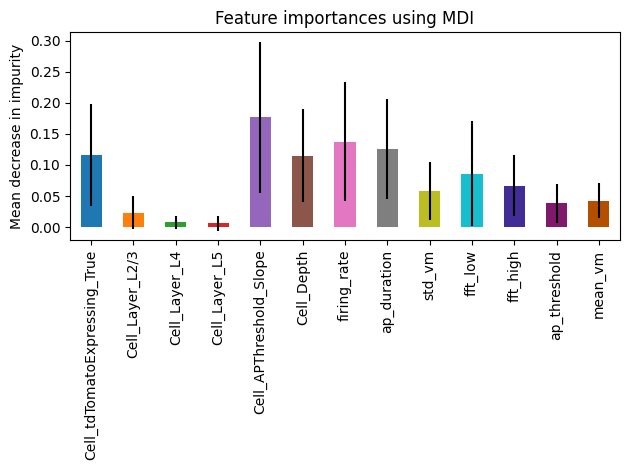

In [91]:
rfclf_pipe.fit(X, y)
importances = rfclf_pipe.named_steps.clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfclf_pipe.named_steps.clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=rfclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, color=colors)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

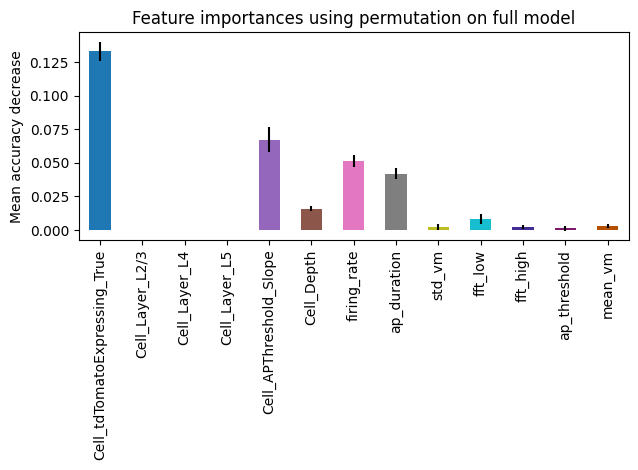

In [95]:
result = permutation_importance(
    rfclf_pipe.named_steps.clf, preprocessing_pipe.fit_transform(X), y, n_repeats=10, random_state=42, n_jobs=2, sample_weight=raw_predictors_free_whisking["cell_type"].apply(lambda x : class_weights[x])
)
forest_importances = pd.Series(result.importances_mean, index=rfclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color=colors)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()